# EDA on review text
- correlation / chi2 of TFidf versus rating

preproccessing: stop word removal , punctuation , 
maybe look for words similar to company and remove  

- models for predicting rating (regression / or classification)
    - ML models TDiDF + RF, log reg, CatBoost, naive bayes 
    - NN language models (simple LSTM / vs bidirectional 2-3 layers) 
    - BERT + regression



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter


# Standard plotly imports
import plotly.figure_factory as ff
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=False)
init_notebook_mode(connected=False)

from tqdm import tqdm
tqdm.pandas()
#from matplotlib_venn import venn2

import pickle
import json

import re

from scipy.stats import ttest_ind, f_oneway, pearsonr

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import adjusted_mutual_info_score, v_measure_score
from sklearn.cluster import DBSCAN
from sklearn.utils.multiclass import unique_labels


from sklearn.metrics import classification_report, confusion_matrix,  accuracy_score, r2_score, f1_score

from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC
# lightgbm for classification
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

/Users/riccardoscott/opt/anaconda3/envs/happyjobs/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [2]:
secs = json.load(open('glassdoor_scraper/secrets.json', 'r'))

In [3]:
df = pd.read_json('data/Reviews_small_run_cleaned.jl',
           lines=True)

In [4]:
df.shape

(458805, 25)

In [5]:
df.columns

Index(['company', 'review_url', 'title', 'overall_rating', 'employee_role',
       'review_date', 'featured_review', 'pros', 'cons', 'work_life_balance',
       'culture_values', 'career_opportunities', 'compensation_and_benefits',
       'senior_management', 'employee_location', 'recommend_bar', 'recommends',
       'outlook', 'ceo_approval', 'employee_current',
       'employee_time_working_full', 'employee_time_working_years', 'all_text',
       'all_text_tokens', 'language'],
      dtype='object')

# Sample and only keep English

In [6]:
df = df[df['language']=='english']

In [7]:
df = df.sample(10000)

# Word clouds

In [8]:
from wordcloud import WordCloud

def plot_word_cloud(text, label=''):
    print(' '.join(['#'*20,label, '#'*20]))
    # Create and generate a word cloud image:
    wordcloud = WordCloud(include_numbers=True,
                         height=500,
                         width=500).generate(text)

    # Display the generated image:
    plt.figure(figsize=(7,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    plt.show()

#################### title ####################


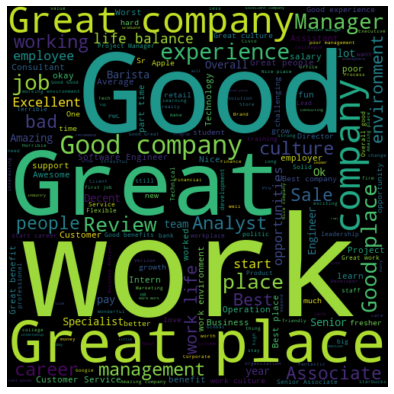

#################### pros ####################


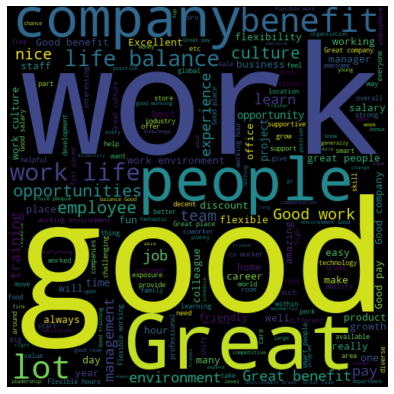

#################### cons ####################


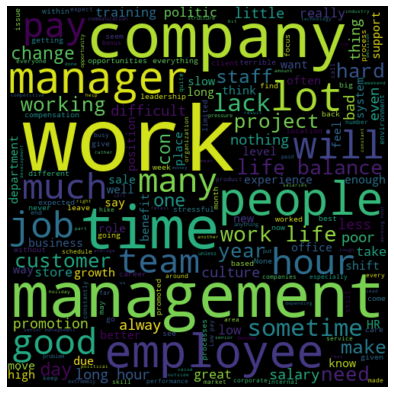

In [9]:
text = ' '.join(df['title'].to_list())
plot_word_cloud(text, label='title')

text = ' '.join(df['pros'].to_list())
plot_word_cloud(text, label='pros')

text = ' '.join(df['cons'].to_list())
plot_word_cloud(text, label='cons')

# Correlation n-grams to rating

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_selection import chi2, f_regression

from scipy.stats import spearmanr
import  nltk
import ray
import spacy

## pre-processing 

In [11]:
from spacy import displacy

In [ ]:
253 - 700

In [12]:
nlp = spacy.load('en')

merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents)

sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)



In [13]:
doc = nlp(df['all_text'].str.lower().iloc[10])

displacy.render(doc, style = "ent",jupyter = True)

In [135]:
def numbers_to_NUM(doc):
    return nlp(' '.join([i.text if i.pos_!='NUM' else '__NUM' for i in doc]))

def get_mean_vector_from_sentences(doc):
    vector = np.array([sent.vector for sent in doc.sents]).mean(axis=0)
    return vector

def lemmatize(doc):
    return ' '.join([i.lemma_ for i in doc])

def get_entities(doc):
    entities=[(i.as_doc().text.strip(), i.label_, i.label) for i in doc.ents]
    return entities

@ray.remote
def process_text(text):
    doc = nlp(text)
    
    entities = get_entities(doc)
    
    mean_sent_vector = get_mean_vector_from_sentences(doc)
    vector = doc.vector
    doc = numbers_to_NUM(doc)
    lemmatized_string = lemmatize(doc)
    
    return {'entities': entities,
            'mean_sent_vector':mean_sent_vector,
            'vector': vector,
            'lemmatized_string': lemmatized_string
            }

In [136]:
ray.shutdown()
ray.init()

futures = [process_text.remote(i) for i in df['all_text'].str.lower().to_list()]
text_features = ray.get(futures) # [0, 1, 4, 9]
ray.shutdown()

2020-10-06 21:14:38,746	INFO resource_spec.py:223 -- Starting Ray with 4.59 GiB memory available for workers and up to 2.32 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-06 21:14:39,255	INFO services.py:1191 -- View the Ray dashboard at localhost:8265
2020-10-06 21:14:42,192	WARNING worker.py:1134 -- Warning: The remote function __main__.process_text has size 75162439 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


In [615]:
lemmatized_reviews = pd.Series([f['lemmatized_string'] for f in text_features], 
                              name='lemmatized_reviews')

vectorized_reviews = pd.DataFrame([f['vector'] for f in text_features])

vectorized_sentences_reviews = pd.DataFrame([f['mean_sent_vector'] for f in text_features])

entities_in_reviews = pd.Series([f['entities'] for f in text_features], 
                                index=df.index,
                               name='entities')

## Entities

In [616]:
entities = entities_in_reviews\
    .explode()\
    .dropna()\
    .apply(pd.Series)\
.reset_index()
entities.columns = ['review_index','text', 'label_text', 'label']
entities

review_index           text label_text  label
0           282180          first    ORDINAL    396
1           282180       3 months       DATE    391
2           282180            25%    PERCENT    393
3           282180     john lewis     PERSON    380
4           282180     john lewis     PERSON    380
...            ...            ...        ...    ...
9923        364513     many hours       TIME    392
9924        165425  worst service        ORG    383
9925        107997            one   CARDINAL    397
9926        299673          month       DATE    391
9927        353338          first    ORDINAL    396

[9928 rows x 4 columns]

In [597]:
px.bar(entities.groupby(['text','label_text'])['label'].count()\
       .to_frame().reset_index().sort_values(by='label',
                                             ascending=False)\
       .head(20).sort_values(by='label'),
       y='text',
       x='label',
       color='label_text',
       orientation='h',
      labels={'label':'times occurring in corpus'},
      title='most frequent entity texts (with type) in corpus')

In [598]:
px.bar(entities['label_text'].value_counts().sort_values(),
      orientation='h',
      title='Most frequent entity types in corpus',
      labels={'value':'count'})

In [687]:
# add label texts to corpus
ents_in_revs = entities\
    .groupby('review_index')['label_text']\
    .progress_apply(lambda x: ' '.join(list(x)))

ents_in_revs.head()

100%|██████████| 4613/4613 [00:00<00:00, 42656.45it/s]


review_index
293           ORG
343    GPE PERSON
423       ORG ORG
623          TIME
659       ORG GPE
Name: label_text, dtype: object

In [688]:
ents_2_ratings = ents_in_revs.to_frame().merge(df[['overall_rating']],
                             left_index=True,
                             right_index=True)

In [689]:
ent_tfidf = TfidfVectorizer(stop_words=None, lowercase=False)

ent_pipe = Pipeline([('tfidf',ent_tfidf),
         ('clf', LogisticRegression())])

X=ents_2_ratings['label_text']
y=(ents_2_ratings['overall_rating']>=4).astype(int)
ent_pipe.fit(X,y)

lr = [i[1] for i in ent_pipe.steps if i[0]=='clf'][0]

lr.classes_ if len(lr.classes_)>2 else None

coeffs = pd.DataFrame(lr.coef_, 
             index=lr.classes_ if len(lr.classes_)>2 else ['coeff'], 
             columns=ent_tfidf.get_feature_names()).T
coeffs= coeffs.iloc[np.argsort(coeffs.sum(axis=1)).values[::-1]]
coeffs.style.bar(align='mid',
            color=['#d65f5f', '#5fba7d'])

Language? Take a closer look

In [701]:
test = df.loc[entities[entities['label_text']=='LANGUAGE']['review_index'].unique()][['all_text','overall_rating']]
docs = list(zip(test['overall_rating'],test['all_text'].apply(nlp)))

for i in range(5):
    print(f'RATING: {docs[i][0]}', '*'*50)
    displacy.render(docs[i][1], style = "ent",jupyter = True)

RATING: 4 **************************************************


RATING: 2 **************************************************


RATING: 1 **************************************************


RATING: 4 **************************************************


RATING: 3 **************************************************


In [141]:
entities_by_type = entities.groupby(['label_text'])['text']\
.apply(lambda x: pd.DataFrame(Counter(x).most_common(5),
                             columns=['entity','count']))

In [142]:
entities_by_type

entity  count
label_text                              
CARDINAL    0                 one    249
            1                   1    212
            2                   2    208
            3                   3    151
            4                   4     75
...                           ...    ...
WORK_OF_ART 0                   %      1
            1  job.flexible hours      1
            2                4 am      1
            3       the boys club      1
            4      the "amercian"      1

[87 rows x 2 columns]

In [143]:
for k,v in entities_by_type.reset_index().groupby('label_text')['entity'].apply(list).to_dict().items():
    print(k, '\n', v, '\n','-'*50)

CARDINAL 
 ['one', '1', '2', '3', '4'] 
 --------------------------------------------------
DATE 
 ['daily', 'annual', 'every day', 'years', '2 years'] 
 --------------------------------------------------
EVENT 
 ['4th year', 'chinese new year', 'the "3rd place" and great coffee to really becoming a fast food place with great coffee', 'e.g christmas', 'new years eve/day'] 
 --------------------------------------------------
FAC 
 ['cisco cisco', 'metro', 'heathcare great benefits', 'ericsson 1', 'the crowne plaza hotel'] 
 --------------------------------------------------
GPE 
 ['cisco', 'india', 'london', 'us', 'uk'] 
 --------------------------------------------------
LANGUAGE 
 ['english', 'french', 'german'] 
 --------------------------------------------------
LAW 
 ['regulations', 'the "40 hour per week', '9hrs/day', '-sales compensation plan rewards mediocrity'] 
 --------------------------------------------------
LOC 
 ['europe', 'earth', 'asia', 'the bay area', 'bay area'] 
 -

In [144]:
px.bar(entities_by_type.reset_index().sort_values(by='count',
                                                 ascending=False),
      x='label_text',
      y='count',
       color='count',
      hover_data=['entity'],
      title='entities extracted')

## Most correlated tokens

### vectorize

In [148]:
def make_tfidf(text, max_df, min_df, ngram_range=(1, 4), stop_words='english'):
    tfidf_vec = TfidfVectorizer(stop_words=stop_words,
                                ngram_range=ngram_range,
                                strip_accents='unicode',
                                max_df=max_df,
                                min_df=min_df
                                )

    text_vec = tfidf_vec.fit_transform(text)
    return tfidf_vec


def get_vocab_stopwords_tfidf(tfidf_vec):
    vocab = tfidf_vec.get_feature_names()
    stopwords = tfidf_vec.stop_words_
    vocab_stopwords = pd.Series({'max_df': tfidf_vec.max_df,
                                 'min_df': tfidf_vec.min_df,
                                 'vocab': vocab,
                                 'vocab_size': len(vocab),
                                 'stopwords': stopwords,
                                 'stopwords_size': len(stopwords)}
                                )
    return vocab_stopwords


def get_vocab_stopwords_from_max_min_df(text, max_df, min_df, ngram_range=(1, 4), stop_words='english'):
    tfidf_vec = make_tfidf(text, max_df, min_df, ngram_range, stop_words)
    return get_vocab_stopwords_tfidf(tfidf_vec)


def plot_ngrams_in_vocab(tfidf):
    vocab = pd.Series(tfidf.get_feature_names())
    fig = px.bar(vocab.str.split().apply(len).value_counts().sort_index(),
                 labels={'index': 'N-gram length',
                         'value': 'count'},
                 title='n-gram counts in vocab',
                 width=500)

    fig.layout.update(showlegend=False,
                      annotations=[dict(xref='paper',
                                        yref='paper',
                                        x=1., y=1.07,
                                        showarrow=False,
                                        text=' '.join(['<b>{} :</b> {}\t'.format(k, v)
                                                       for k, v in dict(ngram_range=tfidf.ngram_range,
                                                                        max_df=tfidf.max_df,
                                                                        min_df=tfidf.min_df).items()]),
                                        )])
    fig.show()


def get_word_stats(tfidf, text, ratings):
    text_vec = tfidf.transform(text).toarray()

    word_mask = text_vec != 0

    word_count = word_mask.sum(axis=0)

    ratings = ratings.reshape(-1, 1)
    masked_ratings = np.ma.masked_array(
        np.ones(word_mask.shape) * ratings,
        mask=word_mask)

    word_rating_mean = np.ma.mean(masked_ratings, axis=0).data
    word_rating_median = np.ma.median(masked_ratings, axis=0).data
    word_rating_std = np.ma.std(masked_ratings, axis=0).data
    
    word_rating_w_mean = np.average(ratings * np.ones(text_vec.shape), 
           weights=text_vec,
          axis=0)
    

    return pd.DataFrame({'ngram': tfidf.get_feature_names(),
                         'count': word_count,
                         'word_rating_mean': word_rating_mean,
                         'word_rating_std': word_rating_std,
                         'word_rating_median': word_rating_median,
                        'word_rating_w_mean':word_rating_w_mean})\
        .sort_values(by='count')


def plot_top_ngrams(tfidf, text, ratings, topN=20):
    ngram_counts = get_word_stats(tfidf, text, ratings)

    fig = px.bar(ngram_counts.tail(topN),
                 y='ngram',
                 x='count',
                 color='word_rating_w_mean',
                 title='Most frequent n-grams in text',
                 width=600,
                 height=600//20*topN
                 )

    fig.layout.update(showlegend=False,
                      annotations=[dict(xref='paper',
                                        yref='paper',
                                        x=1., y=1.07,
                                        showarrow=False,
                                        text=' '.join(['<b>{} :</b> {}\t'.format(k, v)
                                                       for k, v in dict(ngram_range=tfidf.ngram_range,
                                                                        max_df=tfidf.max_df,
                                                                        min_df=tfidf.min_df).items()]),
                                        )])
    fig.show()

In [149]:
# add the 'pron' pronoun lemma that replaces you , your etc in lemmatization to the stopwords
additional_stopwords = ['pron']
my_stop_words = ENGLISH_STOP_WORDS.union(additional_stopwords)

# try some tfidf settings
max_df_range=(0.5, 0.85, 0.99)
min_df_range=(0.001, 0.005, 0.01,0.05,0.1)

max_min_combs = [(i,j) for i in max_df_range  for j in min_df_range]

vocab_stopwords_summary = []
for max_df, min_df in tqdm(max_min_combs):

    vocab_stopwords = get_vocab_stopwords_from_max_min_df(text,
                                                          max_df, 
                                                          min_df, 
                                                          ngram_range = (1, 4),
                                                         stop_words=my_stop_words)
    vocab_stopwords_summary.append(vocab_stopwords)

vocab_stopwords_summary = pd.concat(vocab_stopwords_summary, axis=1).T

100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


In [151]:
# max_df has no effect on vocab size
# pick a setting with relatively small vocab to get an easy overview of interesting words and n-grams

In [152]:
max_df=0.5
min_df=0.005
ngram_range=(1,4)

tfidf_vec = make_tfidf(text,
                       max_df, 
                       min_df, 
                       ngram_range = (1, 4), 
                       stop_words=my_stop_words)

In [153]:
# n-gram dist
plot_ngrams_in_vocab(tfidf_vec)

In [154]:
#top words and the mean rating of the reviews they occur in
ratings = df['overall_rating'].to_numpy()
plot_top_ngrams(tfidf_vec, text, ratings, topN=30)

### Spearman

In [155]:
@ray.remote
def get_spearman(feat_lab):
    # get spearman correlation from features and labels (ratings) per token
    token,feature, labels = feat_lab
    out = spearmanr(feature, labels)
    return {'token':token,
        'correlation':out[0],
           'p_val':out[1]}


text_vec = tfidf_vec.transform(text).toarray()
labels = df['overall_rating']

pairs_to_correlate = [(token,text_vec[:,i], labels.values) 
                      for i,token in enumerate(tfidf_vec.get_feature_names())]

ray.init()
futures = [get_spearman.remote(feat_lab) for feat_lab in pairs_to_correlate]
result = ray.get(futures) 
ray.shutdown()

2020-10-06 21:17:04,765	INFO resource_spec.py:223 -- Starting Ray with 5.18 GiB memory available for workers and up to 2.61 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-06 21:17:05,284	INFO services.py:1191 -- View the Ray dashboard at localhost:8265


In [156]:
spearman = pd.DataFrame(result)


spearman[(np.abs(spearman['correlation']) > 0.1) &
         (spearman['p_val'] < 0.05)]\
    .sort_values(by='correlation',
                 ascending=False)\
    .style.bar(subset=['correlation'],
               align='mid',
               color=['#d65f5f', '#5fba7d'])

### chi2 

In [157]:
labels = df['overall_rating']  # > df['overall_rating'].median()).astype(int)
N = 5  # top N
chi2s = []
for target in labels.unique():
    features_chi2 = chi2(text_vec, labels == target)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    chi2s.append({'target': target,
                  'unigrams': unigrams[-N:],
                  'bigrams': bigrams[-N:]})

In [158]:
pd.DataFrame(chi2s).apply(pd.Series.explode).set_index('target').sort_index()

unigrams            bigrams
target                               
1         terrible    poor management
1            toxic      __date __date
1         horrible        expect work
1             join  __cardinal __date
1            awful   __percent __date
2         employee       good company
2              bad         place work
2       management      great company
2            great    poor management
2             poor         treat like
3          average      great culture
3             okay        great place
3            great      great company
3               ok         place work
3            place       company work
4             poor       good working
4              bad       overall good
4         terrible       good company
4             good     bad management
4       management          good work
5             love       company work
5             poor         work great
5          awesome         place work
5            great      great company
5          amazing        great place